 use neural network to predict the change in the ecmwf-eps from the previous cycle run 12 hours ago for days 9-14
 ### current model features
- the difference between the new ecmwf forecast for day 9 and the previous emcwf-eps forecast for day 9[x]
- the difference between the new emcwf-eps forecast for day 8 and the previous emcwf-eps forecast for day 8[x]
- the difference between the new gfs-ens-bc forecast for days 9-14 and the previous emcwf-eps forecast for days 9-14[x]
- the difference between the new cmc-ens forecast for days 9-14 and the new gfs-ens-bc  forecast for days 9-14[x]

### new feature ideas
- rain data
- wind data
- past errors
- ???

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from datetime import datetime, time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import copy
from meteostat import Stations, Daily

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
path = "RawData"

In [4]:
def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    date = parts[1]
    time = parts[2]
    return date, time

In [5]:
def get_date(df, file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param df: dataframe containing the date
    :param file: filename containing the time
    :return: datetime object
    """
    #date_str = df[df.iloc[:, 2] == 1].iloc[0]['Date']
    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    #date = datetime.strptime(date_str, '%Y-%m-%d')
    date = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date.date(), time_value)
    return combined_datetime

In [6]:
ecmwf_files = glob.glob(path + '/ecmwf.*.[01][02].gw_hdd.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_eps_files = glob.glob(path + '/ecmwf-eps.*.[01][02].gw_hdd.csv')
ecmwf_eps_sorted_files = sorted(ecmwf_eps_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + '/gfs-ens-bc.*.[01][02].gw_hdd.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + '/cmc-ens.*.[01][02].gw_hdd.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

In [7]:
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_eps_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in master_set]

In [8]:
print(len(ecmwf_sorted_files))
print(len(ecmwf_eps_sorted_files))
print(len(gfs_ens_bc_sorted_files))
print(len(cmc_ens_sorted_files))

3484
3484
3484
3484


### step 1 get changes in ecmwf-eps compared to 12 hours ago for days 9-14

In [9]:
ecmwf_eps_change_df = pd.DataFrame(columns=['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12',
                                  'ecmwf-eps_13', 'ecmwf-eps_14'])

for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8, 14):
        changes.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=ecmwf_eps_change_df.columns, index=[date])
    ecmwf_eps_change_df = pd.concat([ecmwf_eps_change_df, new_row])


## step 2 recreate model

### step 2.1 get difference between the new ecmwf forecast for day 9 and the previous ecmwf-eps forecast for day 9

### problems:
- not all dates are in both sets of data

In [10]:
ecmwf_change_df = pd.DataFrame(columns=['ecmwf_diff_8', 'ecmwf_diff_9',])
for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1]) #one day behind

    ecmwf = ecmwf_df.iloc[8]
    ecmwf_eps = ecmwf_eps_df.iloc[9]

    date = get_date(ecmwf_df, ecmwf_sorted_files[i])
    prev_date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8,10):
        changes.append(ecmwf_df.iloc[day - offset]['Value'] - ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=ecmwf_change_df.columns, index=[date])
    ecmwf_change_df = pd.concat([ecmwf_change_df, new_row])

In [11]:
ecmwf_change_df

### step 2.2 the difference between the new emcwf-eps forecast for day 8 and the previous emcwf-eps forecast for day 8 (not possible as the new ecmwf-eps forecast is not available because it will not be released yet???)

### step 2.3 the difference between the new gfs-ens-bc forecast for days 9-14 and the previous emcwf-eps forecast for days 9-14

In [12]:
gfs_ens_bc_change_df = pd.DataFrame(columns=['gfs-ens-bc_9', 'gfs-ens-bc_10', 'gfs-ens-bc_11', 'gfs-ens-bc_12',
                                  'gfs-ens-bc_13', 'gfs-ens-bc_14'])

for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])

    date = get_date(gfs_ens_bc_df, gfs_ens_bc_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8, 14):
        changes.append(gfs_ens_bc_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=gfs_ens_bc_change_df.columns, index=[date])
    gfs_ens_bc_change_df = pd.concat([gfs_ens_bc_change_df, new_row])

In [13]:
gfs_ens_bc_change_df

### step 2.4 the difference between the new cmc-ens forecast for days 9-14 and the new gfs-ens-bc  forecast for days 9-14

In [14]:
cmc_ens_change_df = pd.DataFrame(columns=['cmc-ens_9', 'cmc-ens_10', 'cmc-ens_11', 'cmc-ens_12',
                                  'cmc-ens_13', 'cmc-ens_14'])

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_ens_df = pd.read_csv(cmc_ens_sorted_files[i])
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    date = get_date(cmc_ens_df, cmc_ens_sorted_files[i])

    changes = []
    for day in range(8, 14):
        changes.append(cmc_ens_df.iloc[day]['Value'] - gfs_ens_bc_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=cmc_ens_change_df.columns, index=[date])
    cmc_ens_change_df = pd.concat([cmc_ens_change_df, new_row])

In [15]:
cmc_ens_change_df

In [16]:
# add month data

In [17]:
cmc_ens_change_df['month'] = cmc_ens_change_df.index.month

In [18]:
def f(i):
    x = 6
    y = 1-(1 * (abs(x-i)/x))
    return y

In [20]:
cmc_ens_change_df['month'] = cmc_ens_change_df['month'].apply(f)

In [21]:
#add weather data

In [22]:
start_day = gfs_ens_bc_change_df.index[0]
end_day = gfs_ens_bc_change_df.index[-1]

# Set time period
start = datetime(int(str(start_day)[:4]), int(str(start_day)[5:7]), int(str(start_day)[8:10]))
end = datetime(int(str(end_day)[:4]), int(str(end_day)[5:7]), int(str(end_day)[8:10]))

# Get daily data
# KCQT0 is Los Angeles
# 71877 is Calgary
data = Daily('DHKZ6', start, end)
data = data.fetch()

In [23]:
temp_data = data[['tavg', 'tmin', 'tmax', 'prcp']]
temp_data = temp_data.diff(1)
temp_data.fillna(0, inplace=True)
temp_data['date'] = temp_data.index.date

In [24]:
gfs_ens_bc_change_df['date'] = gfs_ens_bc_change_df.index.date
merged_df = pd.merge(gfs_ens_bc_change_df, temp_data, on='date', how='left')
merged_df.index = gfs_ens_bc_change_df.index
merged_df.drop(columns=['date'], inplace=True)

In [24]:
gfs_ens_bc_change_df = merged_df

In [26]:
master_df = pd.concat([gfs_ens_bc_change_df, cmc_ens_change_df, ecmwf_change_df, ecmwf_eps_change_df], axis=1)

In [28]:
master_df.fillna(0, inplace=True)

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,tavg,tmin,tmax,prcp,...,cmc-ens_14,month,ecmwf_diff_8,ecmwf_diff_9,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.009,0.006,0.002,0.001,0.013,0.013,0.0,0.0,0.0,0.0,...,-0.012,0.833333,0.000,0.001,0.001,-0.001,0.000,0.000,0.000,0.000
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,0.0,0.0,0.0,0.0,...,-0.016,0.833333,0.002,0.000,0.001,0.000,-0.001,-0.001,-0.001,-0.001
2018-07-12 00:00:00,0.003,0.002,0.002,0.006,0.009,0.020,-0.7,-2.7,1.3,-0.4,...,-0.019,0.833333,0.002,0.001,-0.001,-0.001,0.000,0.000,-0.001,0.001
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,-0.7,-2.7,1.3,-0.4,...,-0.007,0.833333,0.000,0.002,0.000,-0.001,0.001,0.001,0.006,0.003
2018-07-13 00:00:00,0.001,0.002,0.002,0.007,0.019,0.021,2.8,0.4,5.1,0.0,...,-0.013,0.833333,0.000,0.002,0.000,-0.001,-0.001,-0.002,0.000,-0.001


### random forest - mse=0.1674

In [30]:
X = master_df.iloc[:, :-6]

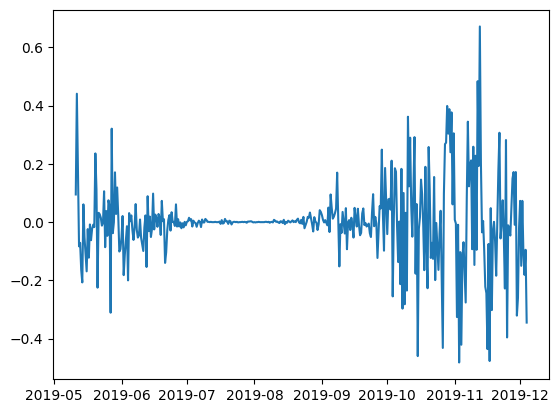

In [31]:
y = master_df.iloc[:, -6:]

In [31]:
plt.plot(y['ecmwf-eps_9'][600:1000])

In [31]:
X

In [ ]:
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=42)

In [ ]:
rf_model.fit(X_train, y_train)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

### RNN (MSE): 0.16733

In [ ]:
master_df

In [ ]:
input_features = master_df.iloc[:, :-6].values ** 2
target_variables = master_df.iloc[:, -6:].values

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_features, target_variables, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False)

# Scale the input features based on the training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Scale the validation and test data based on the training data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data to PyTorch tensors

X_train_tensor = torch.Tensor(X_train_scaled)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val_scaled)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test_scaled)
y_test_tensor = torch.Tensor(y_test)


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Update the hidden state dimensions

        out, _ = self.rnn(x, h0)  # Remove unsqueeze(0) since x already has a batch dimension
        out = self.fc(out[:, -1, :])  # Select the last time step's output for each sequence

        return out

In [ ]:
class ComplexRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(ComplexRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.rnn(x, h0)
        out = self.fc1(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [ ]:
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]
hidden_size = 64
num_layers = 2
dropout = 0.3
lr = 0.01



#model = RNN(input_size, hidden_size, output_size)
model = ComplexRNN(input_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)


num_epochs = 100
sequence_length = 5  # Number of previous days to consider

best_loss = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    # Loop through each sequence in the training data
    for i in range(sequence_length, X_train_tensor.shape[0]):
        # Extract the current sequence and target
        input_seq = X_train_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_train_tensor[i]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print the average training loss for the epoch
    average_loss = total_loss / (X_train_tensor.shape[0] - sequence_length)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}')

    # Validation stage
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0

        for i in range(sequence_length, X_val_tensor.shape[0]):
            input_seq = X_val_tensor[i - sequence_length:i].view(1, sequence_length, -1)
            target_seq = y_val_tensor[i]

            output = model(input_seq)
            val_loss = criterion(output, target_seq.unsqueeze(0))

            total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / (X_val_tensor.shape[0] - sequence_length)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_val_loss}')

        # Check if current model is the best based on validation loss
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            best_model = copy.deepcopy(model)

# After training, use the best model for testing
model = best_model

In [ ]:
#benchmark error
total_mse = 0
c = 0
for i in range(1, len(y_test_tensor)):
    mse = mean_squared_error(y_test_tensor[i], y_test_tensor[i-1])
    total_mse += mse
    c += 1

total_mse/c

In [ ]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    test_loss = 0.0
    predictions = []

    for i in range(sequence_length, X_test_tensor.shape[0]):
        input_seq = X_test_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_test_tensor[i]

        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        test_loss += loss.item()

        # Extract the scalar value from the tensor and append it to predictions
        predictions.append(output.squeeze().tolist())

    average_test_loss = test_loss / (X_test_tensor.shape[0] - sequence_length)
    print(f'Test Loss: {average_test_loss}')

    # Convert the predictions and target values to numpy arrays
    predictions = np.array(predictions)
    targets = y_test_tensor[sequence_length:].numpy()

    # Evaluate the performance using appropriate metrics
    # For example, calculate mean squared error (MSE)
    mse = mean_squared_error(targets, predictions)
    print(f'Mean Squared Error (MSE): {mse}')

### testing ideas


In [33]:
#get weather data

In [33]:
from meteostat import Stations, Daily

start_day = gfs_ens_bc_change_df.index[0]
end_day = gfs_ens_bc_change_df.index[-1]

# Set time period
start = datetime(int(str(start_day)[:4]), int(str(start_day)[5:7]), int(str(start_day)[8:10]))
end = datetime(int(str(end_day)[:4]), int(str(end_day)[5:7]), int(str(end_day)[8:10]))

# Get daily data
# KCQT0 is Los Angeles
# 71877 is Calgary
data = Daily('DHKZ6', start, end)
data = data.fetch()

In [33]:
wind_data = data[['wdir', 'wspd']]

In [36]:
temp_data = data[['tavg', 'tmin', 'tmax', 'prcp']]

In [37]:
temp_data = temp_data.diff(1)

In [38]:
temp_data.fillna(0, inplace=True)
temp_data['date'] = temp_data.index.date

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
DHKZ6,Calgary Int'l CS,CA,AB,71393,<NA>,51.11,-114.0000,1082.0,America/Edmonton,2020-01-01,2022-12-14,2000-01-01,2022-12-13,2000-01-01,2022-01-01,7211.029781
71877,Calgary International Airport,CA,AB,71877,CYYC,51.12,-114.0100,1099.0,America/Edmonton,1955-07-02,2023-05-24,1957-01-02,2023-05-19,1957-01-01,2022-01-01,7637.226218
71235,Cop Upper,CA,AB,71235,CWDU,51.08,-114.2200,1235.0,America/Edmonton,1993-06-07,2023-05-02,1993-06-07,2023-05-18,1993-01-01,2022-01-01,10547.266944
71860,Calgary / Cochrane,CA,AB,71860,CYBW,51.10,-114.3667,1200.0,America/Edmonton,2003-03-30,2023-05-24,2012-08-09,2022-04-24,2015-01-01,2022-01-01,21027.884923
A4Y76,Calgary Springbank Airport,CA,AB,<NA>,<NA>,51.11,-114.3700,1201.0,America/Edmonton,2020-01-01,2022-12-14,2018-10-29,2022-12-12,2018-01-01,2022-01-01,21493.757262


In [39]:
stations = Stations()
stations = stations.nearby(51.063180, -114.071435)
station = stations.fetch(5)

In [40]:
station

In [42]:
gfs_ens_bc_change_df['date'] = gfs_ens_bc_change_df.index.date

In [43]:
merged_df = pd.merge(gfs_ens_bc_change_df, temp_data, on='date', how='left')

In [ ]:
merged_df.index = gfs_ens_bc_change_df.index

In [ ]:
merged_df.drop(columns=['date'], inplace=True)

In [ ]:
# get data from EIA short term energy outlook, such as average heating days